# Relation Extraction with Convolutional Neural Network!

Previously, we successfully performed relation extraction using a simple Bidirectional LSTM architecture. The model included a randomly initialized embedding layer which learned a high dimensional embedding vector for each word. These embedding vectors were then used as input features to the Bidirectional LSTM which consumed sentences as sequences of words. The final hidden state vector was subsequently used by a dense softmax layer to classify the relationship. To improve our results we added word position embeddings to the word embedding vectors denoting the relative distance for each word with respect to the two entities in question. This indicates to the model which words are the two entities whose relationship we are seeking to discover.

However, our previous solution lacked sentence level features and only focused on word level features. Sentence level features have an added value in relation extraction since the type of relationship can be deduced from the global meaning of the sentence and not from individual words. Additionally, we removed relation direction information from the output for our previous model in order to simplify the task (rel(e1,e2) and rel(e2,e2) were both considered the same).

In this notebook, we will use a different approach based on Relation [Classification via Convolutional Deep Network](https://aclanthology.org/C14-1220/). This paper introduces sentence level features for the task of relation extraction which are extracted from word feature by a convolutional neural network (CNN).

## CNN Framework for Relation Extraction

Before we jump into the implementation, let us first review the principles of the methodology introduced in this paper.

In terms of data preprocessing, this approach follows similar procedures to what we have done before. Each word is represented by a feature vector combining its word embedding vector, its position embedding vector with respect to the first entity and its position embedding vector with respect to the second entity. Additionally, the word embedding lookup matrix is initialized using [pretrained weights](https://aclanthology.org/P10-1040/) and then subsequently trained. This has been shown to result in better performance on several occasions when compared to randomly initialized embeddings. The position embedding matrices however, are initialized randomly.

As opposed to our earlier LSTM-based approach which treated sentences as a sequence of words, this approach uses the aforementioned word vectors to extract global sentence level features. This is achieved by using 2D convolutions over the feature vectors. The intuition behind this is that the convolution kernel would encompass several words during each step, and as it slides across the sentence it will be multiplied by a different cluster of words each time. This is analogous to n-gram language models. The authors have found a kernel window size of 3 (trigram) to result in the best performance. A max pooling operation with a tanh nonlinearity is applied on the resulting feature maps over the sentence length direction. The architecture of this approach is shown in the figure below ([source](https://aclanthology.org/P10-1040/)).

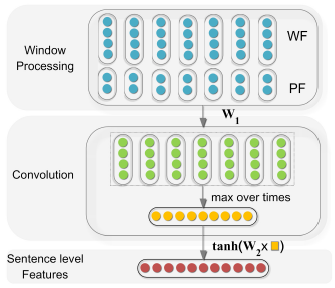

The resulting vector is then used by a softmax dense classifier to produce the output.

## Implementation

This methodology was used on the same [SemEval dataset](https://docs.google.com/document/d/1QO_CnmvNRnYwNWu1-QCAeR5ToQYkXUqFeAJbdEhsq7w/preview) we used previously. To demonstrate it, we will reuse with slight modification the code provided [here](https://github.com/onehaitao/CNN-relation-extraction). We will limit the code we go over to model definition and training. Other code related to data loading and metric calculation will be used as provided in the repository since these were already demonstrated in the previous notebook.

The below cell downloads the necessary Python modules from the Github repository as well as the pretrained word embeddings.

In [ ]:
!git clone https://github.com/onehaitao/CNN-relation-extraction.git
!mv CNN-relation-extraction/* .
!rm -r CNN-relation-extraction/
!wget -q http://metaoptimize.s3.amazonaws.com/hlbl-embeddings-ACL2010/hlbl-embeddings-scaled.EMBEDDING_SIZE=50.txt.gz
!gunzip -q hlbl-embeddings-scaled.EMBEDDING_SIZE\=50.txt.gz
!mv hlbl-embeddings-scaled.EMBEDDING_SIZE\=50.txt embedding/hlbl-embeddings-scaled.EMBEDDING_SIZE\=50.txt
!rm predicted_result.txt result.txt train.log LICENSE README.md

Next, we define the model as described above. We also define a training and testing function which are similar to the functions defined in the previous notebook.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from evaluate import Eval

class CNN(nn.Module):
    def __init__(self, word_vec, class_num, config):
        super().__init__()
        self.word_vec = word_vec
        self.class_num = class_num

        # hyperparameters and others
        self.max_len = config.max_len
        self.word_dim = config.word_dim
        self.pos_dim = config.pos_dim
        self.pos_dis = config.pos_dis

        self.dropout_value = config.dropout
        self.filter_num = config.filter_num
        self.window = config.window
        self.hidden_size = config.hidden_size
        self.dim = self.word_dim + 2 * self.pos_dim # word embeddings + 2*position embeddings

        # net structures and operations
        self.word_embedding = nn.Embedding.from_pretrained(self.word_vec, freeze=False)
        self.pos1_embedding = nn.Embedding(2 * self.pos_dis + 3, self.pos_dim)
        self.pos2_embedding = nn.Embedding(2 * self.pos_dis + 3, self.pos_dim)
        self.conv = nn.Conv2d(
            in_channels=1, # only one channel per sample, example of multiple channels is RGB images
            out_channels=self.filter_num, # number of kernels, we get one output feature map per kernel
            kernel_size=(self.window, self.dim), # window=many words are considered per convolution, dim=size of feature vector
            stride=(1, 1),
            padding=(1, 0),  # same padding
        )
        self.maxpool = nn.MaxPool2d((self.max_len, 1)) # pool over the entire sentence length
        self.linear = nn.Linear(self.filter_num, self.hidden_size)
        self.dense = nn.Linear(self.hidden_size, self.class_num)

        # initialize weight
        # we can keep the default layer initialization but this converges to better results
        nn.init.xavier_normal_(self.pos1_embedding.weight)
        nn.init.xavier_normal_(self.pos2_embedding.weight)
        nn.init.xavier_normal_(self.conv.weight)
        nn.init.constant_(self.conv.bias, 0.)
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.constant_(self.linear.bias, 0.)
        nn.init.xavier_normal_(self.dense.weight)
        nn.init.constant_(self.dense.bias, 0.)

    def encoder_layer(self, token, pos1, pos2):
        # B=batch size, L=sentence length
        word_emb = self.word_embedding(token)  # B*L*word_dim
        pos1_emb = self.pos1_embedding(pos1)  # B*L*pos_dim
        pos2_emb = self.pos2_embedding(pos2)  # B*L*pos_dim
        emb = torch.cat((word_emb, pos1_emb, pos2_emb), dim=-1)
        return emb  # B*L*D, D=word_dim+2*pos_dim

    def conv_layer(self, emb, mask):
        #C=number of kernels
        emb = emb.unsqueeze(dim=1)  # B*1*L*D
        conv = self.conv(emb)  # B*C*L*1

        # mask, remove the effect of 'PAD'
        conv = conv.view(-1, self.filter_num, self.max_len)  # B*C*L
        mask = mask.unsqueeze(dim=1)  # B*1*L
        mask = mask.expand(-1, self.filter_num, -1)  # B*C*L
        conv = conv.masked_fill_(mask.eq(0), float('-inf'))  # B*C*L
        conv = conv.unsqueeze(dim=-1)  # B*C*L*1
        return conv

    def single_maxpool_layer(self, conv):
        pool = self.maxpool(conv)  # B*C*1*1, pooled over L dimension
        pool = pool.view(-1, self.filter_num)  # B*C
        return pool

    def forward(self, data):
        token = data[:, 0, :].view(-1, self.max_len)
        pos1 = data[:, 1, :].view(-1, self.max_len)
        pos2 = data[:, 2, :].view(-1, self.max_len)
        mask = data[:, 3, :].view(-1, self.max_len)
        emb = self.encoder_layer(token, pos1, pos2)
        emb = F.dropout(emb, p=self.dropout_value, training=self.training)
        conv = self.conv_layer(emb, mask)
        pool = self.single_maxpool_layer(conv)
        sentence_feature = self.linear(pool)
        sentence_feature = torch.tanh(sentence_feature)
        sentence_feature = F.dropout(sentence_feature, p=self.dropout_value, training=self.training)
        logits = self.dense(sentence_feature)
        return logits

def train(model, criterion, loader, config):
    train_loader, val_loader, _ = loader
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.L2_decay)

    print('--------------------------------------')
    print('start to train the model ...')

    eval_tool = Eval(config)
    max_f1 = -float('inf')
    for epoch in range(1, config.epoch+1):
        for step, (data, label) in enumerate(train_loader):
            model.train()
            data = data.to(config.device)
            label = label.to(config.device)

            optimizer.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            optimizer.step()

        _, train_loss, _ = eval_tool.evaluate(model, criterion, train_loader)
        val_f1, val_loss, _ = eval_tool.evaluate(model, criterion, val_loader)

        print('[%03d] train_loss: %.3f | val_loss: %.3f | macro f1 on dev: %.4f'
              % (epoch, train_loss, val_loss, val_f1), end=' ')
        # save best model
        if val_f1 > max_f1:
            max_f1 = val_f1
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'model.pkl'))
            print('>>> save models!')
        else:
            print()


def test(model, criterion, loader, config):
    print('--------------------------------------')
    print('start test ...')
    _, _, test_loader = loader
    model.load_state_dict(torch.load(os.path.join(config.model_dir, 'model.pkl')))
    eval_tool = Eval(config)
    f1, test_loss, predict_label = eval_tool.evaluate(model, criterion, test_loader)
    print('test_loss: %.3f | macro f1 on test:  %.4f' % (test_loss, f1))
    return predict_label

To begin training, let us first load the experimental configurations such as number of epochs, learning rate. We keep the default configurations which are the results of hyperparameter tuning done in the paper.

In [ ]:
import sys
from config import Config

sys.argv = [''] # provide empty argument to Config to keep default parameters
config = Config()
config.print_config()

Here, we load the pretrained word embeddings and dataset using the provided functions.

In [ ]:
from utils import WordEmbeddingLoader, RelationLoader, SemEvalDataLoader

word2id, word_vec = WordEmbeddingLoader(config).load_embedding()
rel2id, id2rel, class_num = RelationLoader(config).get_relation()
loader = SemEvalDataLoader(rel2id, word2id, config)

train_loader = loader.get_train()
val_loader = loader.get_dev()
test_loader = loader.get_test()
loader = [train_loader, val_loader, test_loader]

Each batch in the dataset is a tuple of (data, labels) as shown below.

Each data sample is made of four elements:
- Word ID vector
- Position vector for entity 1
- Position vector for entity 2
- Mask indicating the position of padding tokens.

We note that in this case, the position vectors are offset by the max position distance which is set to 50 in the Config class.

In [ ]:
for batch in train_loader:
    sample_data = batch[0][0]
    sample_label = batch[1][0]
    break

print(f'Data shape: {sample_data.shape}')
print(f'Word ID: {sample_data[0]}')
print(f'Position vector 1: {sample_data[1]}')
print(f'Position vector 2: {sample_data[2]}')
print(f'Padding mask: {sample_data[3]}')

Finally, we train the model for 20 epochs. The results are written to a txt file which allows us to use the SemEval perl evaluator.

In [ ]:
from run import print_result

model = CNN(word_vec=word_vec, class_num=class_num, config=config)
model = model.to(config.device)
print(model)
criterion = nn.CrossEntropyLoss()

train(model, criterion, loader, config)
predict_label = test(model, criterion, loader, config)
#write results to a txt file
print_result(predict_label, id2rel)

CNN(
  (word_embedding): Embedding(246123, 50)
  (pos1_embedding): Embedding(103, 5)
  (pos2_embedding): Embedding(103, 5)
  (conv): Conv2d(1, 200, kernel_size=(3, 60), stride=(1, 1), padding=(1, 0))
  (maxpool): MaxPool2d(kernel_size=(100, 1), stride=(100, 1), padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=200, out_features=100, bias=True)
  (dense): Linear(in_features=100, out_features=19, bias=True)
)
--------------------------------------
start to train the model ...
[001] train_loss: 2.479 | val_loss: 2.489 | macro f1 on dev: 0.3167 >>> save models!
[002] train_loss: 1.859 | val_loss: 1.850 | macro f1 on dev: 0.4629 >>> save models!
[003] train_loss: 1.421 | val_loss: 1.437 | macro f1 on dev: 0.5315 >>> save models!
[004] train_loss: 1.184 | val_loss: 1.269 | macro f1 on dev: 0.6462 >>> save models!
[005] train_loss: 0.988 | val_loss: 1.137 | macro f1 on dev: 0.6981 >>> save models!
[006] train_loss: 0.807 | val_loss: 1.046 | macro f1 on dev: 0.7153 >>> sav

Finally, we use the official SemEval scorer to compute the confusion matrix on the test set. The scorer proposes three different ways for computing the confusion matrix in regards to the relationship direction:
- (2*9+1)-way classification: this considers every Relation(direction) combination as a unique class which results in 18 classes plus the other class.
- (9+1)-way classification: this completely ignores relation direction. This is similar to what we computed in the previous notebook.
- (9+1)-way classification, with directionality taken into account: this is the official competition evaluation. It takes into account that both the relation and the direction match but computes the counts on 10 classes only.

In [ ]:
!perl semeval2010_task8_scorer-v1.2.pl proposed_answer.txt predicted_result.txt >> result.txt

Below, we extract the calculated confusion matrices and evaluation metrics from the resulting txt file. There is a consistent improvement in comparison with the previous LSTM-based approach. However, we also note that the Other class had the most misclassifications.

In [ ]:
with open('result.txt', 'r') as results:
    lines = results.readlines()
    cm1 = lines[2:27]
    cm1.extend(lines[56:58])
    cm2 = lines[61:78]
    cm2.extend(lines[99:101])
    cm3 = lines[104:122]
    cm3.extend(lines[142:144])

print('\n'.join(cm1))
print('**********************************************************************************************************************************\n\n')
print('\n'.join(cm2))
print('**********************************************************************************************************************************\n\n')
print('\n'.join(cm3))